In [4]:
import sys
import glob
import os
import math
import pandas as pd
import numpy as np
import geopandas as gp

import matplotlib.pyplot as plt
import rsfuncs as rs

from scipy import stats
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

from pandas.tseries.offsets import MonthEnd, SemiMonthEnd
from datetime import datetime, timedelta
from datetime import datetime as dt

from keras import regularizers, optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Read data
states_file = gp.read_file("../shape/states.shp")
states = states_file[~states_file['STATE_ABBR'].isin(["AK", "HI", "PR", "VI"])]

site_file = gp.read_file("../shape/scan_sites.shp")
sites = site_file[~site_file['state'].isin(["AK", "HI", "PR", "VI"])]

# formate data 
df = pd.read_csv("../data/all_dat_f.csv")
df.rename(columns={ df.columns[0]: "site" , df.columns[1]:"date"}, inplace = True)
df.replace([np.inf, -np.inf], np.nan, inplace = True)
df = df.set_index(pd.to_datetime(df.date))
df['date'] = pd.to_datetime(df.date)

In [6]:
# Filter the data

# Drop days with 2day precip less than 1 mm
df = df[df.precip<1]

# Remove Urban Areas
df = df[df.lc_type != 2]
df = df[df.lc_type != 3]

# Remove sites with <10 datapoints
for i in df.site.unique():
    if len(df[df.site == i]) < 10:
        df = df[df.site != i]

# Calculate spectral indices
df['ndvi'] = (df.B5 - df.B4) / (df.B5 + df.B4)
df["ndmi"] = (df.B5 - df.B6) / (df.B5 + df.B6)
df["evi"] = 2.5*(df.B5 - df.B4) / (df.B5 + 6*df.B4- 7.5*df.B2 + 1)

# For the backscatter columns (df.vv, df.hv), delete any zeros, nans, deal with weird formatting, and calc the mean 
vv_eff = []

for i in df.vv:
    line = i.replace("[","")
    line = line.replace("]","")
    line = ' '.join(line.split())
    data = [float(i) for i in line.split(' ')]
    data = [i for i in data if i !=0.]
    vv_eff.append(np.nanmean(data))
    

hv_eff = []

for i in df.hv:
    if type(i) is float:
        hv_eff.append(np.nan)
    else:
        line = i.replace("[","")
        line = line.replace("]","")
        line = ' '.join(line.split())
        data = [float(i) for i in line.split(' ')]
        data = [i for i in data if i !=0.]
        hv_eff.append(np.nanmean(data))


df['vv'] = vv_eff
df['hv'] = hv_eff

# calc the 12 day means for each site: 
df = df.groupby(['site']).resample('12D').mean().fillna(np.nan).dropna()


In [7]:
# Drop the non interpolated landsat bands
cols = [c for c in df.columns if 'filt' not in c]
df=df[cols]

In [8]:
# One hot encode the landcover types *** figure this out
# df = df.lc_type.astype(str)
one_hot = pd.get_dummies(df.lc_type, drop_first=True )
rdf = pd.concat([df, one_hot], axis = 1)
rdf = rdf.drop(["lc_type"], axis = 1)
# df = rdf.reset_index(level='site')
df = rdf.dropna()
df.columns = df.columns.map(str)

In [13]:
# Add the time lagged predictors 
s1 = df.groupby(level="site").shift(1)
df1 = df.join(s1.rename(columns=lambda x: x+"_t1"))

s2 = df.groupby(level="site").shift(2)
df2 = df1.join(s2.rename(columns=lambda x: x+"_t2"))

df3 = df2.copy()
# s3 = df.groupby(level="site").shift(3)
# df3 = df2.join(s3.rename(columns=lambda x: x+"_t3"))

In [14]:
# Drop unnecessary cols 

In [15]:
dropstrs = ['site','precip', 'rzsm_', 'ssm', 'psi_rz', "psi_s"]
dropcols = []

for i in df3.columns:
    for x in dropstrs:
        if x in i:
            dropcols.append(i)
            
df3 = df3.drop(dropcols, axis = 1)

In [16]:
# Reset the index and drop nans 
df = df3.reset_index(level='site')
df = df.dropna()

In [32]:
# Modeling options

EPOCHS = 100
BATCHSIZE = 50
DROPOUT = 0.25
LOSS = 'mse'

Areg = regularizers.l1(0.00005)
Breg = regularizers.l2(0.001)
Kreg = regularizers.l2(1e-15)
Rreg = regularizers.l2(1e-15)

def build_model(input_shape):
    # make the model 
    model = Sequential()
    
    model.add(LSTM(50, input_shape=input_shape, dropout = 0.05,recurrent_dropout=0.05,return_sequences=True,bias_regularizer= Breg))
    model.add(LSTM(25, input_shape=input_shape, dropout = 0.05,recurrent_dropout=0.05,return_sequences=True,bias_regularizer= Breg))
    model.add(LSTM(5, input_shape=input_shape, dropout = 0.05,recurrent_dropout=0.05,bias_regularizer= Breg))

    model.add(Dense(1))
    model.compile(loss=LOSS, optimizer= "Nadam",
                  metrics=['mse'])
    
    return model


In [33]:
out = {"train_preds":[], # rs
       "test_preds":[], # wells
       "train_act":[], # c2vsim
       "test_act":[]  # grace 
        }

Processing 581
Train on 2982 samples, validate on 7 samples
Epoch 1/300
 - 3s - loss: 0.1728 - mse: 0.0931 - val_loss: 0.1269 - val_mse: 0.0478
Epoch 2/300
 - 0s - loss: 0.1531 - mse: 0.0741 - val_loss: 0.1084 - val_mse: 0.0299
Epoch 3/300
 - 0s - loss: 0.1339 - mse: 0.0557 - val_loss: 0.0890 - val_mse: 0.0112
Epoch 4/300
 - 0s - loss: 0.1170 - mse: 0.0395 - val_loss: 0.0789 - val_mse: 0.0019
Epoch 5/300
 - 0s - loss: 0.1117 - mse: 0.0349 - val_loss: 0.0784 - val_mse: 0.0022
Epoch 6/300
 - 0s - loss: 0.1097 - mse: 0.0338 - val_loss: 0.0775 - val_mse: 0.0022
Epoch 7/300
 - 0s - loss: 0.1084 - mse: 0.0334 - val_loss: 0.0766 - val_mse: 0.0022
Epoch 8/300
 - 0s - loss: 0.1068 - mse: 0.0327 - val_loss: 0.0759 - val_mse: 0.0024
Epoch 9/300
 - 0s - loss: 0.1051 - mse: 0.0319 - val_loss: 0.0751 - val_mse: 0.0025
Epoch 10/300
 - 0s - loss: 0.1040 - mse: 0.0316 - val_loss: 0.0741 - val_mse: 0.0024
Epoch 11/300
 - 0s - loss: 0.1027 - mse: 0.0313 - val_loss: 0.0740 - val_mse: 0.0031
Epoch 12/300
 

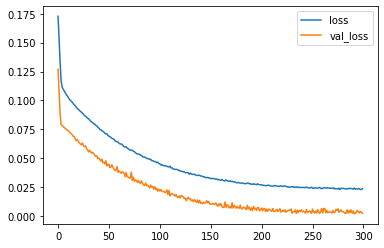

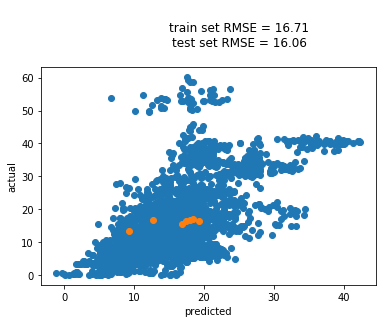

Processing 808
Train on 2941 samples, validate on 48 samples
Epoch 1/300
 - 3s - loss: 0.1868 - mse: 0.1071 - val_loss: 0.0917 - val_mse: 0.0125
Epoch 2/300
 - 0s - loss: 0.1657 - mse: 0.0868 - val_loss: 0.0834 - val_mse: 0.0049
Epoch 3/300
 - 0s - loss: 0.1459 - mse: 0.0676 - val_loss: 0.0785 - val_mse: 6.7332e-04
Epoch 4/300
 - 0s - loss: 0.1265 - mse: 0.0489 - val_loss: 0.0830 - val_mse: 0.0060
Epoch 5/300
 - 0s - loss: 0.1146 - mse: 0.0378 - val_loss: 0.0953 - val_mse: 0.0191
Epoch 6/300
 - 0s - loss: 0.1116 - mse: 0.0357 - val_loss: 0.0998 - val_mse: 0.0244
Epoch 7/300
 - 0s - loss: 0.1102 - mse: 0.0351 - val_loss: 0.0970 - val_mse: 0.0226
Epoch 8/300
 - 0s - loss: 0.1082 - mse: 0.0340 - val_loss: 0.0964 - val_mse: 0.0228
Epoch 9/300
 - 0s - loss: 0.1067 - mse: 0.0334 - val_loss: 0.0961 - val_mse: 0.0234
Epoch 10/300
 - 0s - loss: 0.1051 - mse: 0.0327 - val_loss: 0.0954 - val_mse: 0.0236
Epoch 11/300
 - 0s - loss: 0.1039 - mse: 0.0324 - val_loss: 0.0936 - val_mse: 0.0226
Epoch 12/

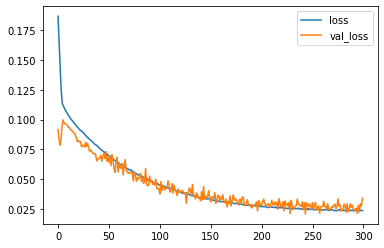

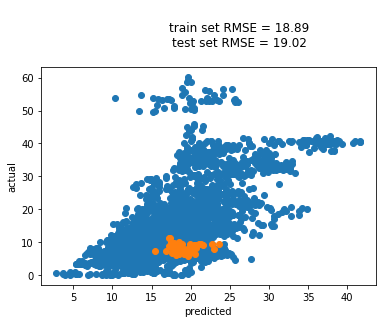

Processing 2006
Train on 2948 samples, validate on 41 samples
Epoch 1/300
 - 3s - loss: 0.1735 - mse: 0.0938 - val_loss: 0.3427 - val_mse: 0.2635
Epoch 2/300
 - 0s - loss: 0.1605 - mse: 0.0815 - val_loss: 0.3124 - val_mse: 0.2339
Epoch 3/300
 - 0s - loss: 0.1456 - mse: 0.0673 - val_loss: 0.2691 - val_mse: 0.1913
Epoch 4/300
 - 0s - loss: 0.1281 - mse: 0.0506 - val_loss: 0.2134 - val_mse: 0.1364
Epoch 5/300
 - 0s - loss: 0.1150 - mse: 0.0382 - val_loss: 0.1686 - val_mse: 0.0923
Epoch 6/300
 - 0s - loss: 0.1119 - mse: 0.0359 - val_loss: 0.1596 - val_mse: 0.0843
Epoch 7/300
 - 0s - loss: 0.1099 - mse: 0.0348 - val_loss: 0.1566 - val_mse: 0.0821
Epoch 8/300
 - 0s - loss: 0.1080 - mse: 0.0339 - val_loss: 0.1548 - val_mse: 0.0812
Epoch 9/300
 - 0s - loss: 0.1066 - mse: 0.0333 - val_loss: 0.1505 - val_mse: 0.0778
Epoch 10/300
 - 0s - loss: 0.1051 - mse: 0.0327 - val_loss: 0.1474 - val_mse: 0.0756
Epoch 11/300
 - 0s - loss: 0.1036 - mse: 0.0321 - val_loss: 0.1447 - val_mse: 0.0738
Epoch 12/300

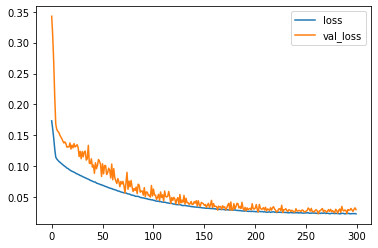

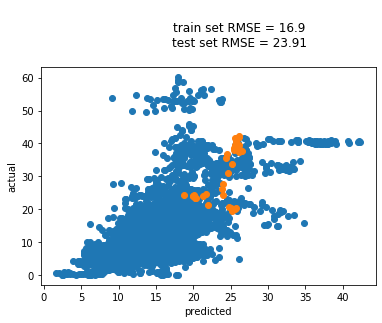

Processing 2015
Train on 2948 samples, validate on 41 samples
Epoch 1/300
 - 3s - loss: 0.1808 - mse: 0.1011 - val_loss: 0.0802 - val_mse: 0.0010
Epoch 2/300
 - 0s - loss: 0.1561 - mse: 0.0772 - val_loss: 0.0794 - val_mse: 9.1003e-04
Epoch 3/300
 - 0s - loss: 0.1350 - mse: 0.0567 - val_loss: 0.0880 - val_mse: 0.0102
Epoch 4/300
 - 0s - loss: 0.1194 - mse: 0.0419 - val_loss: 0.1035 - val_mse: 0.0265
Epoch 5/300
 - 0s - loss: 0.1138 - mse: 0.0371 - val_loss: 0.1080 - val_mse: 0.0318
Epoch 6/300
 - 0s - loss: 0.1113 - mse: 0.0354 - val_loss: 0.1036 - val_mse: 0.0283
Epoch 7/300
 - 0s - loss: 0.1094 - mse: 0.0343 - val_loss: 0.0980 - val_mse: 0.0236
Epoch 8/300
 - 0s - loss: 0.1078 - mse: 0.0336 - val_loss: 0.0925 - val_mse: 0.0189
Epoch 9/300
 - 0s - loss: 0.1062 - mse: 0.0329 - val_loss: 0.0887 - val_mse: 0.0160
Epoch 10/300
 - 0s - loss: 0.1049 - mse: 0.0325 - val_loss: 0.0854 - val_mse: 0.0136
Epoch 11/300
 - 0s - loss: 0.1037 - mse: 0.0322 - val_loss: 0.0838 - val_mse: 0.0129
Epoch 12

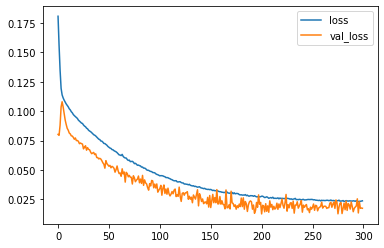

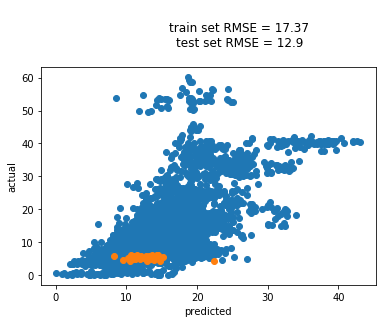

Processing 2019
Train on 2937 samples, validate on 52 samples
Epoch 1/300
 - 3s - loss: 0.1608 - mse: 0.0811 - val_loss: 0.1826 - val_mse: 0.1034
Epoch 2/300
 - 0s - loss: 0.1347 - mse: 0.0557 - val_loss: 0.1454 - val_mse: 0.0669
Epoch 3/300
 - 0s - loss: 0.1184 - mse: 0.0401 - val_loss: 0.1178 - val_mse: 0.0401
Epoch 4/300
 - 0s - loss: 0.1124 - mse: 0.0349 - val_loss: 0.1095 - val_mse: 0.0326
Epoch 5/300
 - 0s - loss: 0.1109 - mse: 0.0342 - val_loss: 0.1104 - val_mse: 0.0344
Epoch 6/300
 - 0s - loss: 0.1091 - mse: 0.0333 - val_loss: 0.1130 - val_mse: 0.0378
Epoch 7/300
 - 0s - loss: 0.1078 - mse: 0.0329 - val_loss: 0.1136 - val_mse: 0.0393
Epoch 8/300
 - 0s - loss: 0.1062 - mse: 0.0322 - val_loss: 0.1142 - val_mse: 0.0408
Epoch 9/300
 - 0s - loss: 0.1047 - mse: 0.0316 - val_loss: 0.1176 - val_mse: 0.0450
Epoch 10/300
 - 0s - loss: 0.1031 - mse: 0.0309 - val_loss: 0.1182 - val_mse: 0.0465
Epoch 11/300
 - 0s - loss: 0.1026 - mse: 0.0312 - val_loss: 0.1168 - val_mse: 0.0460
Epoch 12/300

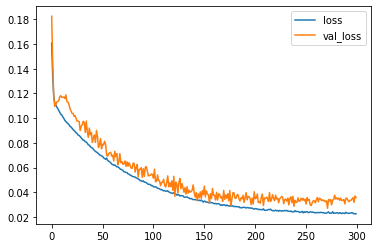

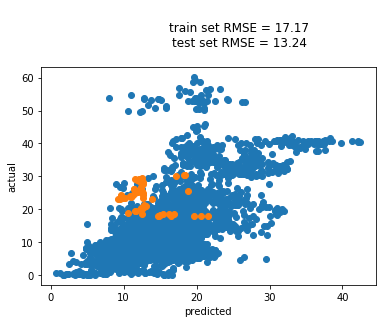

Processing 2021
Train on 2950 samples, validate on 39 samples
Epoch 1/300
 - 3s - loss: 0.1745 - mse: 0.0948 - val_loss: 0.1097 - val_mse: 0.0305
Epoch 2/300
 - 0s - loss: 0.1478 - mse: 0.0688 - val_loss: 0.0908 - val_mse: 0.0123
Epoch 3/300
 - 0s - loss: 0.1259 - mse: 0.0476 - val_loss: 0.0814 - val_mse: 0.0036
Epoch 4/300
 - 0s - loss: 0.1152 - mse: 0.0376 - val_loss: 0.0834 - val_mse: 0.0064
Epoch 5/300
 - 0s - loss: 0.1128 - mse: 0.0361 - val_loss: 0.0832 - val_mse: 0.0071
Epoch 6/300
 - 0s - loss: 0.1106 - mse: 0.0347 - val_loss: 0.0826 - val_mse: 0.0073
Epoch 7/300
 - 0s - loss: 0.1085 - mse: 0.0335 - val_loss: 0.0816 - val_mse: 0.0073
Epoch 8/300
 - 0s - loss: 0.1070 - mse: 0.0329 - val_loss: 0.0813 - val_mse: 0.0078
Epoch 9/300
 - 0s - loss: 0.1055 - mse: 0.0323 - val_loss: 0.0801 - val_mse: 0.0075
Epoch 10/300
 - 0s - loss: 0.1044 - mse: 0.0321 - val_loss: 0.0794 - val_mse: 0.0077
Epoch 11/300
 - 0s - loss: 0.1028 - mse: 0.0313 - val_loss: 0.0773 - val_mse: 0.0065
Epoch 12/300

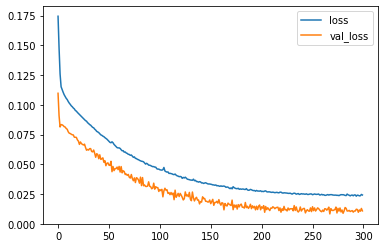

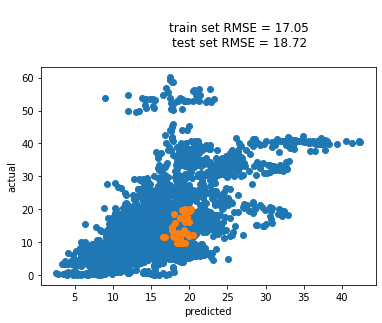

Processing 2069
Train on 2950 samples, validate on 39 samples
Epoch 1/300
 - 3s - loss: 0.1732 - mse: 0.0935 - val_loss: 0.1939 - val_mse: 0.1147
Epoch 2/300
 - 0s - loss: 0.1477 - mse: 0.0687 - val_loss: 0.1547 - val_mse: 0.0762
Epoch 3/300
 - 0s - loss: 0.1276 - mse: 0.0493 - val_loss: 0.1186 - val_mse: 0.0408
Epoch 4/300
 - 0s - loss: 0.1164 - mse: 0.0389 - val_loss: 0.1002 - val_mse: 0.0232
Epoch 5/300
 - 0s - loss: 0.1137 - mse: 0.0370 - val_loss: 0.0959 - val_mse: 0.0198
Epoch 6/300
 - 0s - loss: 0.1109 - mse: 0.0351 - val_loss: 0.0934 - val_mse: 0.0181
Epoch 7/300
 - 0s - loss: 0.1093 - mse: 0.0343 - val_loss: 0.0925 - val_mse: 0.0181
Epoch 8/300
 - 0s - loss: 0.1075 - mse: 0.0334 - val_loss: 0.0911 - val_mse: 0.0176
Epoch 9/300
 - 0s - loss: 0.1059 - mse: 0.0327 - val_loss: 0.0894 - val_mse: 0.0168
Epoch 10/300
 - 0s - loss: 0.1044 - mse: 0.0321 - val_loss: 0.0869 - val_mse: 0.0152
Epoch 11/300
 - 0s - loss: 0.1031 - mse: 0.0316 - val_loss: 0.0854 - val_mse: 0.0145
Epoch 12/300

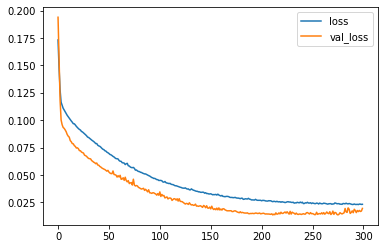

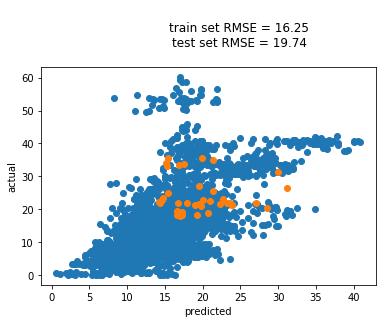

Processing 2074
Train on 2948 samples, validate on 41 samples
Epoch 1/300
 - 3s - loss: 0.1839 - mse: 0.1042 - val_loss: 0.0951 - val_mse: 0.0159
Epoch 2/300
 - 0s - loss: 0.1598 - mse: 0.0808 - val_loss: 0.0837 - val_mse: 0.0052
Epoch 3/300
 - 0s - loss: 0.1377 - mse: 0.0594 - val_loss: 0.0792 - val_mse: 0.0014
Epoch 4/300
 - 0s - loss: 0.1191 - mse: 0.0416 - val_loss: 0.0897 - val_mse: 0.0127
Epoch 5/300
 - 0s - loss: 0.1122 - mse: 0.0355 - val_loss: 0.0985 - val_mse: 0.0223
Epoch 6/300
 - 0s - loss: 0.1106 - mse: 0.0347 - val_loss: 0.0963 - val_mse: 0.0210
Epoch 7/300
 - 0s - loss: 0.1088 - mse: 0.0338 - val_loss: 0.0940 - val_mse: 0.0196
Epoch 8/300
 - 0s - loss: 0.1072 - mse: 0.0331 - val_loss: 0.0926 - val_mse: 0.0190
Epoch 9/300
 - 0s - loss: 0.1057 - mse: 0.0325 - val_loss: 0.0907 - val_mse: 0.0180
Epoch 10/300
 - 0s - loss: 0.1047 - mse: 0.0324 - val_loss: 0.0887 - val_mse: 0.0169
Epoch 11/300
 - 0s - loss: 0.1025 - mse: 0.0310 - val_loss: 0.0887 - val_mse: 0.0178
Epoch 12/300

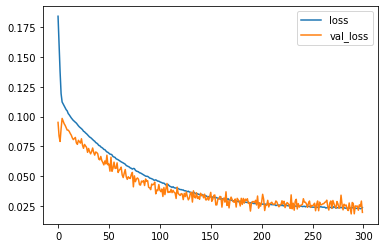

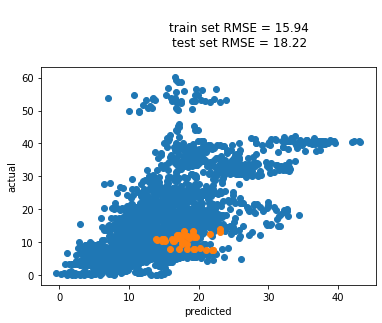

Processing 2106
Train on 2950 samples, validate on 39 samples
Epoch 1/300
 - 3s - loss: 0.1801 - mse: 0.1004 - val_loss: 0.1014 - val_mse: 0.0222
Epoch 2/300
 - 0s - loss: 0.1653 - mse: 0.0863 - val_loss: 0.0905 - val_mse: 0.0120
Epoch 3/300
 - 0s - loss: 0.1483 - mse: 0.0700 - val_loss: 0.0799 - val_mse: 0.0021
Epoch 4/300
 - 0s - loss: 0.1284 - mse: 0.0509 - val_loss: 0.0800 - val_mse: 0.0029
Epoch 5/300
 - 0s - loss: 0.1146 - mse: 0.0379 - val_loss: 0.0936 - val_mse: 0.0174
Epoch 6/300
 - 0s - loss: 0.1114 - mse: 0.0355 - val_loss: 0.0959 - val_mse: 0.0205
Epoch 7/300
 - 0s - loss: 0.1099 - mse: 0.0349 - val_loss: 0.0915 - val_mse: 0.0170
Epoch 8/300
 - 0s - loss: 0.1083 - mse: 0.0341 - val_loss: 0.0899 - val_mse: 0.0163
Epoch 9/300
 - 0s - loss: 0.1068 - mse: 0.0335 - val_loss: 0.0875 - val_mse: 0.0149
Epoch 10/300
 - 0s - loss: 0.1051 - mse: 0.0328 - val_loss: 0.0863 - val_mse: 0.0145
Epoch 11/300
 - 0s - loss: 0.1037 - mse: 0.0322 - val_loss: 0.0853 - val_mse: 0.0143
Epoch 12/300

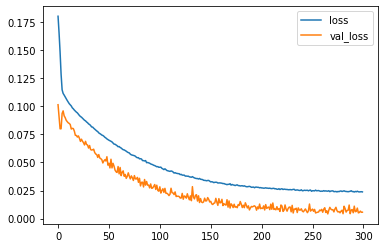

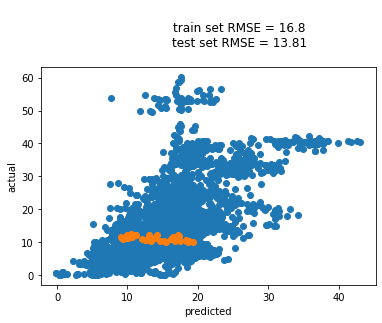

Processing 2107
Train on 2985 samples, validate on 4 samples
Epoch 1/300
 - 3s - loss: 0.1723 - mse: 0.0926 - val_loss: 0.1052 - val_mse: 0.0260
Epoch 2/300
 - 0s - loss: 0.1439 - mse: 0.0649 - val_loss: 0.0879 - val_mse: 0.0094
Epoch 3/300
 - 0s - loss: 0.1236 - mse: 0.0453 - val_loss: 0.0784 - val_mse: 6.6479e-04
Epoch 4/300
 - 0s - loss: 0.1142 - mse: 0.0366 - val_loss: 0.0771 - val_mse: 8.7409e-05
Epoch 5/300
 - 0s - loss: 0.1120 - mse: 0.0353 - val_loss: 0.0762 - val_mse: 8.7396e-05
Epoch 6/300
 - 0s - loss: 0.1102 - mse: 0.0343 - val_loss: 0.0753 - val_mse: 3.8207e-05
Epoch 7/300
 - 0s - loss: 0.1084 - mse: 0.0334 - val_loss: 0.0746 - val_mse: 2.8251e-04
Epoch 8/300
 - 0s - loss: 0.1067 - mse: 0.0327 - val_loss: 0.0740 - val_mse: 5.5378e-04
Epoch 9/300
 - 0s - loss: 0.1055 - mse: 0.0323 - val_loss: 0.0736 - val_mse: 0.0010
Epoch 10/300
 - 0s - loss: 0.1039 - mse: 0.0316 - val_loss: 0.0731 - val_mse: 0.0014
Epoch 11/300
 - 0s - loss: 0.1029 - mse: 0.0314 - val_loss: 0.0724 - val_m

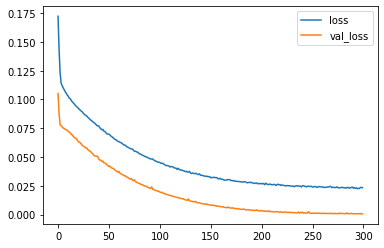

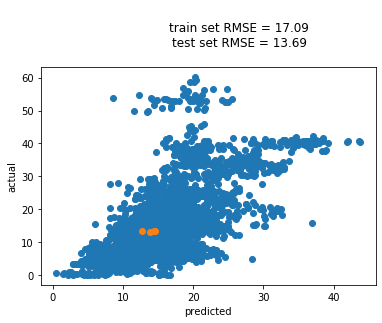

Processing 2108
Train on 2953 samples, validate on 36 samples
Epoch 1/300
 - 4s - loss: 0.1795 - mse: 0.0998 - val_loss: 0.0794 - val_mse: 2.2292e-04
Epoch 2/300
 - 0s - loss: 0.1530 - mse: 0.0741 - val_loss: 0.0807 - val_mse: 0.0022
Epoch 3/300
 - 0s - loss: 0.1305 - mse: 0.0522 - val_loss: 0.0930 - val_mse: 0.0153
Epoch 4/300
 - 0s - loss: 0.1161 - mse: 0.0385 - val_loss: 0.1085 - val_mse: 0.0315
Epoch 5/300
 - 0s - loss: 0.1120 - mse: 0.0353 - val_loss: 0.1068 - val_mse: 0.0306
Epoch 6/300
 - 0s - loss: 0.1102 - mse: 0.0343 - val_loss: 0.1016 - val_mse: 0.0263
Epoch 7/300
 - 0s - loss: 0.1083 - mse: 0.0333 - val_loss: 0.0965 - val_mse: 0.0221
Epoch 8/300
 - 0s - loss: 0.1065 - mse: 0.0324 - val_loss: 0.0942 - val_mse: 0.0207
Epoch 9/300
 - 0s - loss: 0.1052 - mse: 0.0320 - val_loss: 0.0916 - val_mse: 0.0189
Epoch 10/300
 - 0s - loss: 0.1038 - mse: 0.0314 - val_loss: 0.0882 - val_mse: 0.0165
Epoch 11/300
 - 0s - loss: 0.1025 - mse: 0.0311 - val_loss: 0.0895 - val_mse: 0.0186
Epoch 12

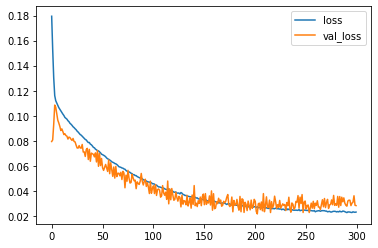

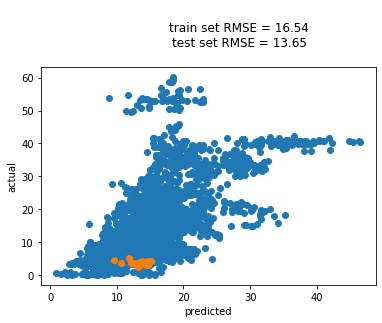

Processing 2111
Train on 2984 samples, validate on 5 samples
Epoch 1/300
 - 4s - loss: 0.1715 - mse: 0.0918 - val_loss: 0.0912 - val_mse: 0.0120
Epoch 2/300
 - 0s - loss: 0.1524 - mse: 0.0735 - val_loss: 0.0825 - val_mse: 0.0040
Epoch 3/300
 - 0s - loss: 0.1334 - mse: 0.0552 - val_loss: 0.0804 - val_mse: 0.0026
Epoch 4/300
 - 0s - loss: 0.1187 - mse: 0.0411 - val_loss: 0.0917 - val_mse: 0.0147
Epoch 5/300
 - 0s - loss: 0.1136 - mse: 0.0369 - val_loss: 0.0959 - val_mse: 0.0198
Epoch 6/300
 - 0s - loss: 0.1115 - mse: 0.0357 - val_loss: 0.0944 - val_mse: 0.0191
Epoch 7/300
 - 0s - loss: 0.1093 - mse: 0.0343 - val_loss: 0.0932 - val_mse: 0.0188
Epoch 8/300
 - 0s - loss: 0.1078 - mse: 0.0337 - val_loss: 0.0934 - val_mse: 0.0199
Epoch 9/300
 - 0s - loss: 0.1060 - mse: 0.0328 - val_loss: 0.0939 - val_mse: 0.0213
Epoch 10/300
 - 0s - loss: 0.1047 - mse: 0.0324 - val_loss: 0.0881 - val_mse: 0.0164
Epoch 11/300
 - 0s - loss: 0.1030 - mse: 0.0315 - val_loss: 0.0879 - val_mse: 0.0170
Epoch 12/300


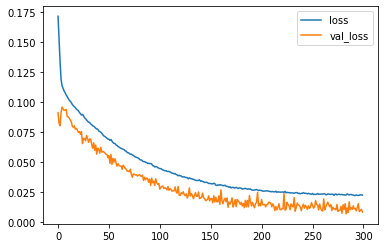

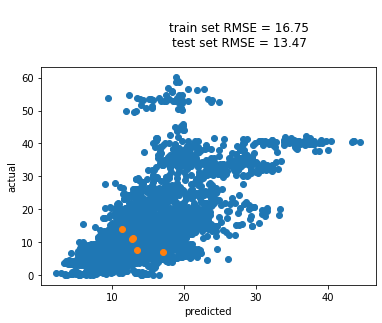

Processing 2116
Train on 2974 samples, validate on 15 samples
Epoch 1/300
 - 4s - loss: 0.1798 - mse: 0.1001 - val_loss: 0.7577 - val_mse: 0.6785
Epoch 2/300
 - 0s - loss: 0.1547 - mse: 0.0758 - val_loss: 0.6557 - val_mse: 0.5772
Epoch 3/300
 - 0s - loss: 0.1326 - mse: 0.0543 - val_loss: 0.5332 - val_mse: 0.4554
Epoch 4/300
 - 0s - loss: 0.1166 - mse: 0.0391 - val_loss: 0.4463 - val_mse: 0.3693
Epoch 5/300
 - 0s - loss: 0.1114 - mse: 0.0347 - val_loss: 0.4453 - val_mse: 0.3691
Epoch 6/300
 - 0s - loss: 0.1091 - mse: 0.0333 - val_loss: 0.4625 - val_mse: 0.3872
Epoch 7/300
 - 0s - loss: 0.1067 - mse: 0.0317 - val_loss: 0.4801 - val_mse: 0.4057
Epoch 8/300
 - 0s - loss: 0.1046 - mse: 0.0305 - val_loss: 0.4975 - val_mse: 0.4240
Epoch 9/300
 - 0s - loss: 0.1030 - mse: 0.0297 - val_loss: 0.5137 - val_mse: 0.4410
Epoch 10/300
 - 0s - loss: 0.1018 - mse: 0.0294 - val_loss: 0.5247 - val_mse: 0.4529
Epoch 11/300
 - 0s - loss: 0.1004 - mse: 0.0290 - val_loss: 0.5375 - val_mse: 0.4666
Epoch 12/300

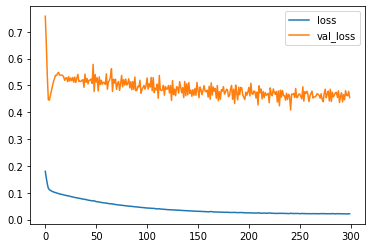

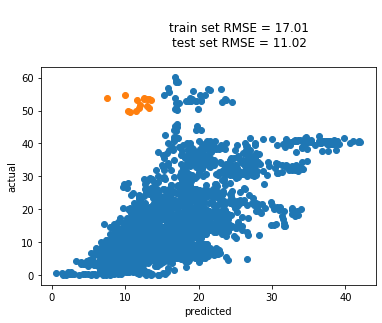

Processing 2117
Train on 2941 samples, validate on 48 samples
Epoch 1/300
 - 4s - loss: 0.1621 - mse: 0.0824 - val_loss: 0.2621 - val_mse: 0.1829
Epoch 2/300
 - 0s - loss: 0.1360 - mse: 0.0571 - val_loss: 0.2073 - val_mse: 0.1288
Epoch 3/300
 - 0s - loss: 0.1202 - mse: 0.0419 - val_loss: 0.1639 - val_mse: 0.0861
Epoch 4/300
 - 0s - loss: 0.1140 - mse: 0.0365 - val_loss: 0.1419 - val_mse: 0.0650
Epoch 5/300
 - 0s - loss: 0.1117 - mse: 0.0350 - val_loss: 0.1358 - val_mse: 0.0597
Epoch 6/300
 - 0s - loss: 0.1099 - mse: 0.0341 - val_loss: 0.1346 - val_mse: 0.0594
Epoch 7/300
 - 0s - loss: 0.1083 - mse: 0.0334 - val_loss: 0.1325 - val_mse: 0.0582
Epoch 8/300
 - 0s - loss: 0.1065 - mse: 0.0324 - val_loss: 0.1317 - val_mse: 0.0583
Epoch 9/300
 - 0s - loss: 0.1049 - mse: 0.0317 - val_loss: 0.1295 - val_mse: 0.0569
Epoch 10/300
 - 0s - loss: 0.1038 - mse: 0.0315 - val_loss: 0.1316 - val_mse: 0.0599
Epoch 11/300
 - 0s - loss: 0.1027 - mse: 0.0313 - val_loss: 0.1294 - val_mse: 0.0586
Epoch 12/300

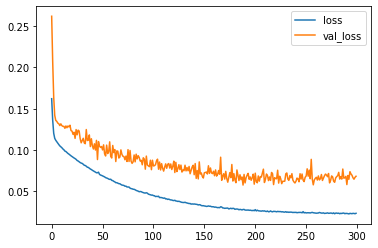

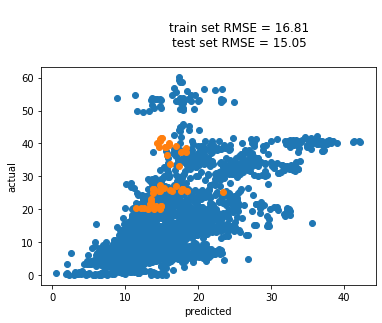

Processing 2118
Train on 2941 samples, validate on 48 samples
Epoch 1/300
 - 4s - loss: 0.1776 - mse: 0.0979 - val_loss: 0.0886 - val_mse: 0.0094
Epoch 2/300
 - 0s - loss: 0.1523 - mse: 0.0734 - val_loss: 0.0830 - val_mse: 0.0045
Epoch 3/300
 - 0s - loss: 0.1314 - mse: 0.0531 - val_loss: 0.0889 - val_mse: 0.0111
Epoch 4/300
 - 0s - loss: 0.1172 - mse: 0.0397 - val_loss: 0.1081 - val_mse: 0.0311
Epoch 5/300
 - 0s - loss: 0.1129 - mse: 0.0362 - val_loss: 0.1164 - val_mse: 0.0402
Epoch 6/300
 - 0s - loss: 0.1107 - mse: 0.0348 - val_loss: 0.1165 - val_mse: 0.0413
Epoch 7/300
 - 0s - loss: 0.1090 - mse: 0.0340 - val_loss: 0.1141 - val_mse: 0.0398
Epoch 8/300
 - 0s - loss: 0.1072 - mse: 0.0331 - val_loss: 0.1119 - val_mse: 0.0384
Epoch 9/300
 - 0s - loss: 0.1058 - mse: 0.0326 - val_loss: 0.1102 - val_mse: 0.0376
Epoch 10/300
 - 0s - loss: 0.1043 - mse: 0.0320 - val_loss: 0.1099 - val_mse: 0.0381
Epoch 11/300
 - 0s - loss: 0.1026 - mse: 0.0311 - val_loss: 0.1096 - val_mse: 0.0387
Epoch 12/300

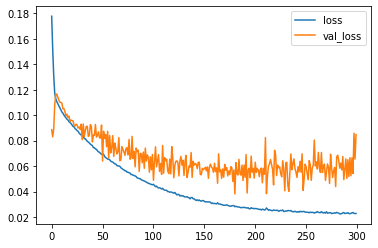

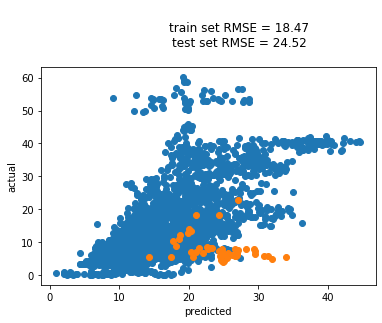

Processing 2119
Train on 2943 samples, validate on 46 samples
Epoch 1/300
 - 4s - loss: 0.1807 - mse: 0.1010 - val_loss: 0.0970 - val_mse: 0.0178
Epoch 2/300
 - 0s - loss: 0.1636 - mse: 0.0846 - val_loss: 0.0876 - val_mse: 0.0091
Epoch 3/300
 - 0s - loss: 0.1461 - mse: 0.0678 - val_loss: 0.0804 - val_mse: 0.0026
Epoch 4/300
 - 0s - loss: 0.1274 - mse: 0.0499 - val_loss: 0.0828 - val_mse: 0.0057
Epoch 5/300
 - 0s - loss: 0.1152 - mse: 0.0384 - val_loss: 0.0960 - val_mse: 0.0197
Epoch 6/300
 - 0s - loss: 0.1121 - mse: 0.0362 - val_loss: 0.0987 - val_mse: 0.0233
Epoch 7/300
 - 0s - loss: 0.1100 - mse: 0.0349 - val_loss: 0.0985 - val_mse: 0.0240
Epoch 8/300
 - 0s - loss: 0.1083 - mse: 0.0341 - val_loss: 0.0970 - val_mse: 0.0234
Epoch 9/300
 - 0s - loss: 0.1069 - mse: 0.0336 - val_loss: 0.0970 - val_mse: 0.0243
Epoch 10/300
 - 0s - loss: 0.1053 - mse: 0.0329 - val_loss: 0.0959 - val_mse: 0.0241
Epoch 11/300
 - 0s - loss: 0.1038 - mse: 0.0323 - val_loss: 0.0958 - val_mse: 0.0249
Epoch 12/300

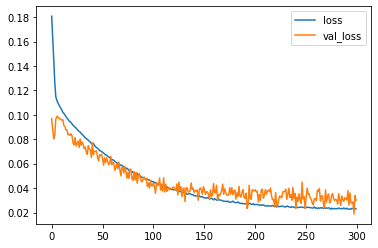

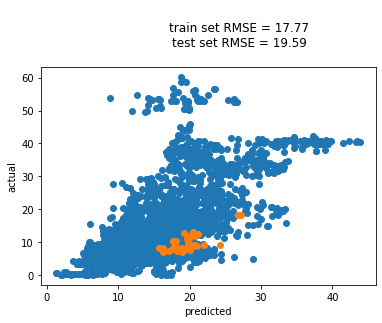

Processing 2121


KeyboardInterrupt: 

In [34]:
for i in df.site.unique():

    print("Processing {}".format(i))
    
    # Hold one out cross validation - loop through sites and select 1 to test on and the rest to train 
    sdf = df[df.site == i]
    y_test = sdf.rzsm
    X_test = sdf.drop(["site","rzsm"], axis=1)

    nsdf = df[df.site != i]
    y_train = nsdf.rzsm 
    X_train = nsdf.drop(["site","rzsm"], axis=1)
        
    # Scale data
#     transformer_x = StandardScaler().fit(X_train)
#     transformer_y = StandardScaler().fit(np.array(y_train).reshape(-1, 1)) 
    
#     transformer_x = MinMaxScaler(feature_range=(0,1)).fit(X_train)
#     transformer_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(y_train).reshape(-1, 1)) 
    
    X_train = transformer_x.transform(X_train)
    y_train = transformer_y.transform(np.array(y_train).reshape(-1, 1))
    X_test = transformer_x.transform(X_test)
    y_test = transformer_y.transform(np.array(y_test).reshape(-1, 1))
    
    # LSTM params
    n_lags = 3
    n_features = 19

    X_train = X_train.reshape((X_train.shape[0], n_lags, 19))
    X_test = X_test.reshape((X_test.shape[0], n_lags, 19))

    input_shape=(X_train.shape[1], X_train.shape[2])
    
    model = build_model(input_shape=input_shape)
    
    # Fit
#     model.fit(X_train, y_train, epochs=1000, batch_size=1000, verbose=1)
    
    train_history = model.fit(X_train, y_train,epochs = 300,
                    batch_size=1000,
                    verbose=2, validation_data=(X_test, y_test))
    loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']
    val_acc = train_history.history['val_mse']

    # Get the predictions
    yhat_train = model.predict(X_train)
    
    trainPredict = transformer_y.inverse_transform(yhat_train.reshape(-1,1))
    trainY = transformer_y.inverse_transform(y_train)
    
    yhat = model.predict(X_test)
    testPredict = transformer_y.inverse_transform(yhat.reshape(-1,1))
    testY = transformer_y.inverse_transform(y_test)

    trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))
    
    out["test_preds"] = testPredict
    out["train_preds"] = trainPredict
    
    out["test_act"] = testY
    out["train_act"] = trainY
    
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['loss', 'val_loss'])
    plt.show()


    plt.scatter(trainPredict, trainY)
    plt.scatter(testPredict, testY)
    plt.title('''
                train set RMSE = {}
                test set RMSE = {}
                '''.format(round(trainScore,2),round(testScore,2)))

    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.show()

In [ ]:
train_history.history.keys()

In [ ]:
for i in df.site.unique():
    sdf = df[df.site == i]
    max_len = 0
    if len(sdf)>max_len:
        max_len = len(sdf)
        answer = i
    else:
        continue

In [ ]:
answer